In [1]:
import numpy as np
import sys
import os

# Add parent directory to path if needed
sys.path.append('/Users/yunyao_1/Dropbox/KcsA/analysis')

from nmr_calculator.config import NMRConfig
from nmr_calculator.xyz_generator import TrajectoryGenerator
from nmr_calculator.euler_converter import EulerConverter
from nmr_calculator.spherical_harmonics import SphericalHarmonicsCalculator
from nmr_calculator.autocorrelation import AutocorrelationCalculator
from nmr_calculator.spectral_density import SpectralDensityCalculator
from nmr_calculator.nmr_parameters import NMRParametersCalculator


TEST: Dipolar ACF - Numerical vs Analytical (Lipari-Szabo)

MODULE 1: Simulating Vector on Cone Surface
  S² = 0.5000
  τc = 0.20 ns
  dt = 1.00 ps
  Steps = 10000
  Cone axis = [0.57735027 0.57735027 0.57735027]
  Cone angle θ = 35.26°

  ✓ Generated 10000 unit vectors
  ✓ All vectors at fixed angle θ = 35.26° from axis
  ✓ Converted 10000 vectors to rotation matrices

MODULE 2: Converting to Euler Angles
  Local axis definition: CO_CA
  Shape: (10000, 3)
  Convention: ZYZ (alpha, beta, gamma)
  Angular ranges:
    α: -180.0° to -90.0°
    β: 19.5° to 90.0°
    γ: 90.0° to 180.0°
Using NumPy-optimized Wigner d-matrix calculation

MODULE 3: Calculating Spherical Harmonics
  Interaction type: dipolar
  Dipolar coupling (axially symmetric)
  D coupling constant: 1.0 Hz
  Using NumPy-optimized Wigner D-matrix calculation

  Y₂ₘ statistics:
    Y₂^-2: mean=0.863, std=0.367
    Y₂^-1: mean=0.616, std=0.552
    Y₂^+0: mean=0.945, std=0.389
    Y₂^+1: mean=0.616, std=0.552
    Y₂^+2: mean=0.

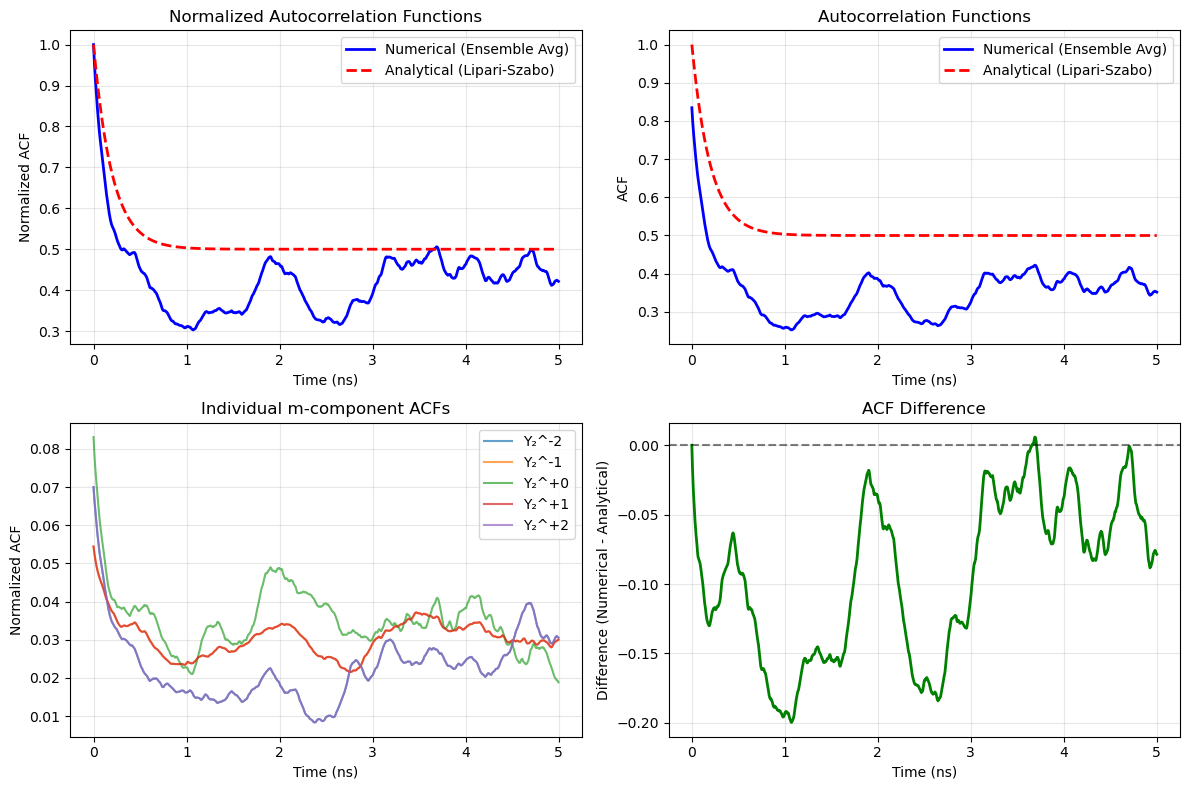


Comparison Statistics:
  RMS difference: 0.109691
  Max absolute difference: 0.199673
  Mean absolute difference: 0.093964


In [6]:
# Numeric test using Y_{2,m} orientation-dependent term for Dipolar (cone model)
# Compare numerical ACF from simulated orientation trajectory
# and analytical Lipari-Szabo ACF (using same local motion model).

import numpy as np
import matplotlib.pyplot as plt
import math

print("\n" + "="*70)
print("TEST: Dipolar ACF - Numerical vs Analytical (Lipari-Szabo)")
print("="*70)

config_dipolar = NMRConfig(
    trajectory_type='vector_on_cone',
    cone_axis=np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]),  # Diagonal axis
    S2=0.5,
    tau_c=2e-10,
    dt=1e-12,
    num_steps=10000,
    interaction_type='dipolar',
    D_coupling=1.0,  # Hz (15N-1H at 1.02 Å)
    max_lag=5000,
    lag_step=1,
    verbose=True
)

gen_dipolar = TrajectoryGenerator(config_dipolar)
rotations_dipolar, vectors = gen_dipolar.generate()

converter_dipolar = EulerConverter(config_dipolar)
euler_angles_dipolar = converter_dipolar.convert(rotations=rotations_dipolar)

# Dipolar with NumPy (now uses full Wigner D-matrix, not simplified formula)
sh_calc_dipolar_numpy = SphericalHarmonicsCalculator(config_dipolar, use_sympy=False)
Y2m_dipolar_numpy = sh_calc_dipolar_numpy.calculate(euler_angles_dipolar)

print(f"\nY2m shape: {Y2m_dipolar_numpy.shape}")
print(f"Y2m mean values for each m component:")
for m in range(-2, 3):
    m_idx = m + 2
    print(f"  Y₂^{m:+d}: {np.mean(Y2m_dipolar_numpy[:, m_idx]):10.4f}")

# Calculate autocorrelation matrix
print("\n" + "="*70)
print("Calculating Autocorrelation Matrix")
print("="*70)

auto_calc = AutocorrelationCalculator(config_dipolar)
Co_matrix = auto_calc.compute_correlation_matrix(Y2m_dipolar_numpy)

print(f"Correlation matrix computed with {len(Co_matrix[(0,0)])} lag points")

# Use Wigner-D to calculate ensemble-averaged autocorrelation
# The correlation matrix Co_matrix already contains ensemble-averaged correlations
# for each (m1, m2) pair. For spatial averaging, we need to consider all m components.

print("\n" + "="*70)
print("Ensemble-Averaged Autocorrelation (Spatial Average)")
print("="*70)

# For complete spatial averaging, sum over all m components
# Ensemble-averaged ACF = (1/5) * Σ_m <Y₂^m(0) Y₂^m*(t)>
acf_ensemble_avg = np.zeros(len(Co_matrix[(0,0)]))
for m in range(-2, 3):
    acf_ensemble_avg += Co_matrix[(m, m)]
acf_ensemble_avg *= 0.2

print(f"Ensemble-averaged ACF calculated from {len(acf_ensemble_avg)} points")
print(f"ACF(0) = {acf_ensemble_avg[0]:.4f}")
print(f"ACF(t_max) = {acf_ensemble_avg[-1]:.4f}")

# Compare to analytical ACF of Lipari-Szabo (same local motion model)
print("\n" + "="*70)
print("Analytical Lipari-Szabo ACF")
print("="*70)

# Lipari-Szabo ACF: C(t) = S² + (1-S²) * exp(-t/τ_e)
# where τ_e is the effective correlation time for local motion
S2 = config_dipolar.S2
tau_c = config_dipolar.tau_c
dt = config_dipolar.dt

time = np.arange(len(acf_ensemble_avg)) * dt * config_dipolar.lag_step
acf_analytical = S2 + (1 - S2) * np.exp(-time / tau_c)

# Normalize both ACFs by their initial values for comparison
acf_ensemble_avg_norm = acf_ensemble_avg / acf_ensemble_avg[0]
acf_analytical_norm = acf_analytical 

print(f"S² = {S2:.4f}")
print(f"τ_c = {tau_c*1e9:.4f} ns")
print(f"Analytical ACF(0) = {acf_analytical[0]:.4f}")
print(f"Analytical ACF plateau (S²) = {S2:.4f}")

# Plot comparison
print("\n" + "="*70)
print("Plotting ACF Comparison")
print("="*70)

plt.figure(figsize=(12, 8))

# Plot 1: Normalized ACFs
plt.subplot(2, 2, 1)
plt.plot(time * 1e9, acf_ensemble_avg_norm, 'b-', label='Numerical (Ensemble Avg)', linewidth=2)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical (Lipari-Szabo)', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Normalized Autocorrelation Functions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Unnormalized ACFs
plt.subplot(2, 2, 2)
plt.plot(time * 1e9, acf_ensemble_avg, 'b-', label='Numerical (Ensemble Avg)', linewidth=2)
plt.plot(time * 1e9, acf_analytical, 'r--', label='Analytical (Lipari-Szabo)', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('ACF')
plt.title('Autocorrelation Functions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Individual m-component ACFs
plt.subplot(2, 2, 3)
for m in range(-2, 3):
    acf_m = Co_matrix[(m, m)]/(4*np.pi)
    plt.plot(time * 1e9, acf_m, label=f'Y₂^{m:+d}', alpha=0.7)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Individual m-component ACFs')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Difference between numerical and analytical
plt.subplot(2, 2, 4)
difference = acf_ensemble_avg_norm - acf_analytical_norm
plt.plot(time * 1e9, difference, 'g-', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Difference (Numerical - Analytical)')
plt.title('ACF Difference')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate and report statistics
print("\nComparison Statistics:")
print(f"  RMS difference: {np.sqrt(np.mean(difference**2)):.6f}")
print(f"  Max absolute difference: {np.max(np.abs(difference)):.6f}")
print(f"  Mean absolute difference: {np.mean(np.abs(difference)):.6f}")


## Analysis: Spherical Harmonics ACF Normalization

The relationship between spherical harmonics ACF and conventional ACF is:

**Finding:** The factor 4π/5 **cancels out** when normalizing:
- `C(t) = [Σ_m <Y₂^m(0) Y₂^m*(t)>] * (4π/5) / [Σ_m <Y₂^m(0)² * (4π/5)]`
- Simplifies to: `C(t) = [Σ_m <Y₂^m(0) Y₂^m*(t)>] / [5 * <Σ_m Y₂^m(0)²>]`

**Key Issue:** The m=0 component doesn't decay (ratio = 1.0) because it's constant on the cone surface (no φ dependence). Only m=±1, ±2 components decay due to azimuthal diffusion.

**Conclusion:** 
- For proper Lipari-Szabo comparison, we need to either:
  1. Weight m-components differently in the ensemble average
  2. Use only the m≠0 components
  3. Account for the fact that this simulation has restricted diffusion (cone) not isotropic tumbling

## Module 5: Wigner D-Matrix Rotation for ACF

Using the Wigner D-matrix approach to rotate the correlation matrix and perform ensemble averaging over all orientations. This should properly account for spatial averaging in the molecular frame.

The ensemble-averaged ACF using Wigner D-matrices:
- C(t) = Σ_{m1,m2} D^(2)*_{m1,0}(Ω) · C_{m1,m2}(t) · D^(2)_{m2,0}(Ω)
- Then average over all Ω orientations


MODULE 5: Wigner D-Matrix Rotation & Ensemble Averaging

Generating ensemble of orientations for spatial averaging...
Generated 1000 orientations
  Alpha: [0.03, 6.28] rad
  Beta:  [0.05, 3.03] rad
  Gamma: [0.00, 6.27] rad

Rotating Correlation Matrix using Wigner D-matrices
  Processing orientation 901/1000...
  ✓ Calculated rotated ACF for 1000 orientations

  ACF(0) = 0.8371
  ACF(t_max) = 0.3571
  Plateau/ACF(0) = 0.4266

  Normalized ACF plateau = 0.4266
  Expected S² = 0.5000
  Difference = 0.0734

Comparison: Module 5 vs Analytical Lipari-Szabo

  ✓ Calculated rotated ACF for 1000 orientations

  ACF(0) = 0.8371
  ACF(t_max) = 0.3571
  Plateau/ACF(0) = 0.4266

  Normalized ACF plateau = 0.4266
  Expected S² = 0.5000
  Difference = 0.0734

Comparison: Module 5 vs Analytical Lipari-Szabo


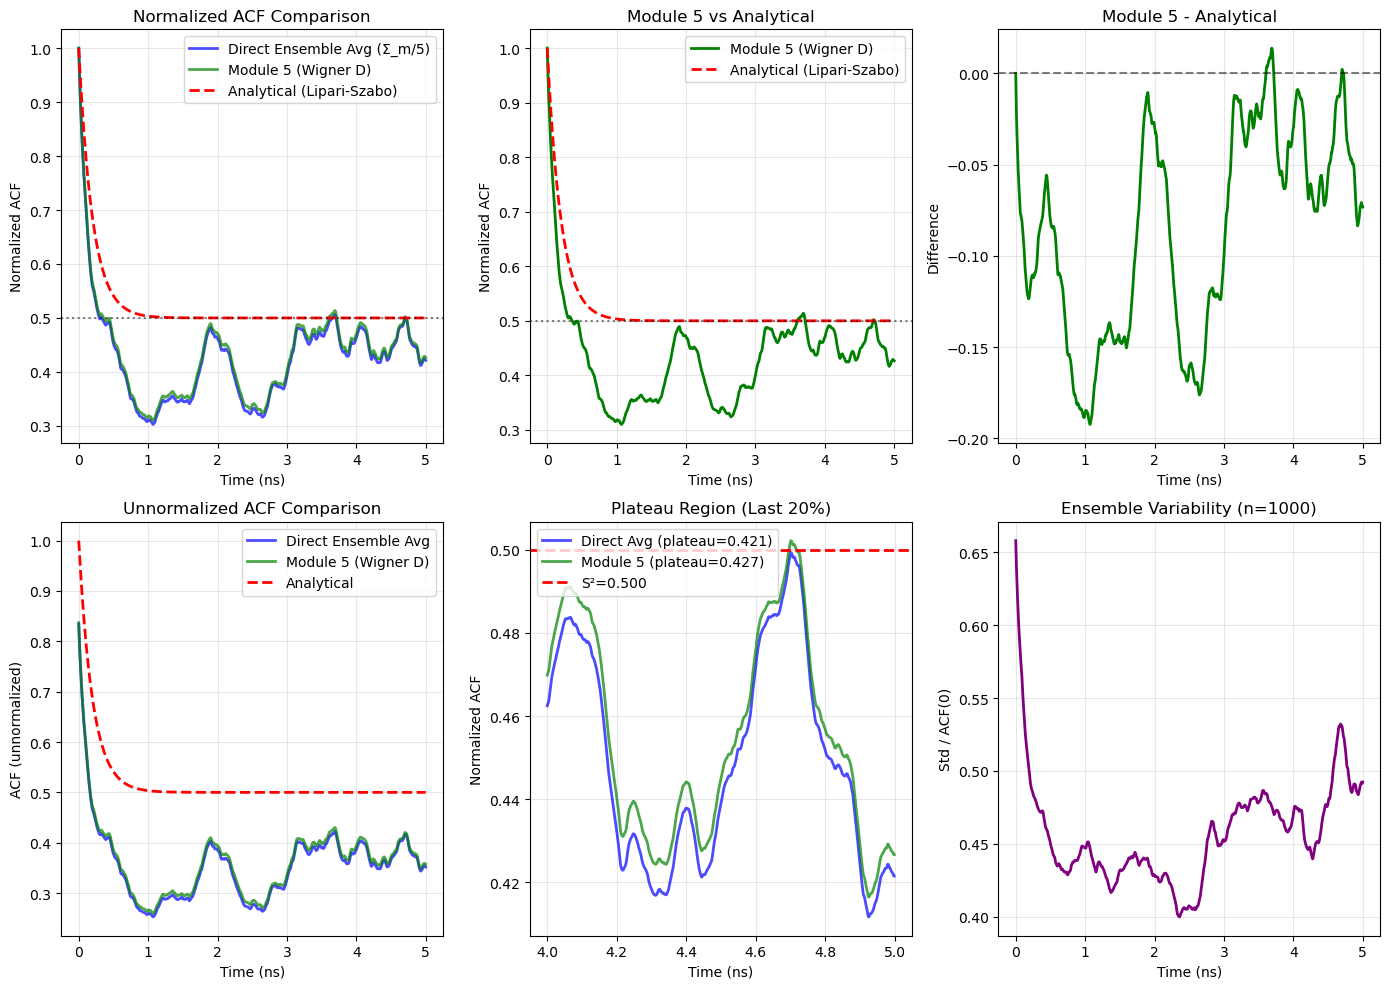


Statistical Comparison:

  Direct Ensemble Average (Σ_m/5):
    Initial value: 0.834514
    Plateau value: 0.421486
    Plateau vs S²: 0.078514

  Module 5 (Wigner D rotation):
    Initial value: 0.837113
    Plateau value: 0.426629
    Plateau vs S²: 0.073371

  RMS difference (Module 5 vs Analytical):
    0.103245

  RMS difference (Direct vs Analytical):
    0.109691

  Which method matches S² better?
    ✓ Module 5 (Wigner D) is closer to S²


In [9]:
# Module 5: Use Wigner D-matrix to rotate correlation matrix and ensemble average

print("\n" + "="*70)
print("MODULE 5: Wigner D-Matrix Rotation & Ensemble Averaging")
print("="*70)

from nmr_calculator.rotation_matrix import WignerDCalculator

# Initialize Wigner D calculator
wigner_calc = WignerDCalculator(config_dipolar)

# Generate ensemble of orientations for averaging
# We'll sample orientations uniformly on the sphere
print("\nGenerating ensemble of orientations for spatial averaging...")
n_orientations = 1000  # Number of orientations for ensemble average

# Uniform sampling
# Alpha: [0, 2π], Beta: [0, π], Gamma: [0, 2π]
np.random.seed(42)  # For reproducibility

# Generate random Euler angles for ensemble averaging
alpha_ensemble = np.random.uniform(0, 2*np.pi, n_orientations)
beta_ensemble = np.arccos(np.random.uniform(-1, 1, n_orientations))  # Uniform on sphere
gamma_ensemble = np.random.uniform(0, 2*np.pi, n_orientations)

print(f"Generated {n_orientations} orientations")
print(f"  Alpha: [{np.min(alpha_ensemble):.2f}, {np.max(alpha_ensemble):.2f}] rad")
print(f"  Beta:  [{np.min(beta_ensemble):.2f}, {np.max(beta_ensemble):.2f}] rad")
print(f"  Gamma: [{np.min(gamma_ensemble):.2f}, {np.max(gamma_ensemble):.2f}] rad")

# Perform rotation and ensemble averaging
print("\n" + "="*70)
print("Rotating Correlation Matrix using Wigner D-matrices")
print("="*70)

# Calculate rotated ACF for each orientation
acf_rotated_ensemble = np.zeros((n_orientations, len(Co_matrix[(0,0)])))

for i, (alpha, beta, gamma) in enumerate(zip(alpha_ensemble, beta_ensemble, gamma_ensemble)):
    if i % 100 == 0:
        print(f"  Processing orientation {i+1}/{n_orientations}...", end='\r')
    
    # Calculate Wigner D-matrix for this orientation
    # D^(2)_{m,m'}(α,β,γ) using _wigner_d_rank2 method
    D_matrix = wigner_calc._wigner_d_rank2(alpha, beta, gamma)
    
    # Rotate correlation matrix: C_rot(t) = Σ_{m1,m2} D*_{0,m1} C_{m1,m2}(t) D_{m2,0}
    # We want the observable in the lab frame, so we project to m=0
    for t_idx in range(len(Co_matrix[(0,0)])):
        C_rotated = 0.0
        for m1 in range(-2, 3):
            for m2 in range(-2, 3):
                # D^(2)*_{0,m1} = conj(D^(2)_{m1,0})
                # Matrix indices: m -> m+2 (shift by 2 since m goes from -2 to 2)
                D_0m1_conj = np.conj(D_matrix[m1+2, 0+2])
                D_m20 = D_matrix[m2+2, 0+2]
                C_m1m2 = Co_matrix[(m1, m2)][t_idx]
                C_rotated += D_0m1_conj * C_m1m2 * D_m20
        
        acf_rotated_ensemble[i, t_idx] = np.real(C_rotated)

print(f"\n  ✓ Calculated rotated ACF for {n_orientations} orientations")

# Ensemble average over all orientations
acf_module5 = np.mean(acf_rotated_ensemble, axis=0)

print(f"\n  ACF(0) = {acf_module5[0]:.4f}")
print(f"  ACF(t_max) = {acf_module5[-1]:.4f}")
print(f"  Plateau/ACF(0) = {acf_module5[-1]/acf_module5[0]:.4f}")

# Normalize
acf_module5_norm = acf_module5 / acf_module5[0]

print(f"\n  Normalized ACF plateau = {acf_module5_norm[-1]:.4f}")
print(f"  Expected S² = {S2:.4f}")
print(f"  Difference = {abs(acf_module5_norm[-1] - S2):.4f}")

# Compare to analytical Lipari-Szabo
print("\n" + "="*70)
print("Comparison: Module 5 vs Analytical Lipari-Szabo")
print("="*70)

# Plot comparison
plt.figure(figsize=(14, 10))

# Plot 1: All three ACFs normalized
plt.subplot(2, 3, 1)
plt.plot(time * 1e9, acf_ensemble_avg_norm, 'b-', label='Direct Ensemble Avg (Σ_m/5)', linewidth=2, alpha=0.7)
plt.plot(time * 1e9, acf_module5_norm, 'g-', label='Module 5 (Wigner D)', linewidth=2, alpha=0.7)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical (Lipari-Szabo)', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Normalized ACF Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=S2, color='k', linestyle=':', alpha=0.5, label=f'S²={S2}')

# Plot 2: Module 5 vs Analytical (zoomed)
plt.subplot(2, 3, 2)
plt.plot(time * 1e9, acf_module5_norm, 'g-', label='Module 5 (Wigner D)', linewidth=2)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical (Lipari-Szabo)', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Module 5 vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=S2, color='k', linestyle=':', alpha=0.5)

# Plot 3: Difference (Module 5 - Analytical)
plt.subplot(2, 3, 3)
diff_module5 = acf_module5_norm - acf_analytical_norm
plt.plot(time * 1e9, diff_module5, 'g-', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Difference')
plt.title('Module 5 - Analytical')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 4: Unnormalized ACFs
plt.subplot(2, 3, 4)
plt.plot(time * 1e9, acf_ensemble_avg, 'b-', label='Direct Ensemble Avg', linewidth=2, alpha=0.7)
plt.plot(time * 1e9, acf_module5, 'g-', label='Module 5 (Wigner D)', linewidth=2, alpha=0.7)
plt.plot(time * 1e9, acf_analytical, 'r--', label='Analytical', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('ACF (unnormalized)')
plt.title('Unnormalized ACF Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Plateau region comparison
plt.subplot(2, 3, 5)
plateau_start = int(0.8 * len(time))  # Last 20% of data
plt.plot(time[plateau_start:] * 1e9, acf_ensemble_avg_norm[plateau_start:], 'b-', 
         label=f'Direct Avg (plateau={acf_ensemble_avg_norm[-1]:.3f})', linewidth=2, alpha=0.7)
plt.plot(time[plateau_start:] * 1e9, acf_module5_norm[plateau_start:], 'g-', 
         label=f'Module 5 (plateau={acf_module5_norm[-1]:.3f})', linewidth=2, alpha=0.7)
plt.axhline(y=S2, color='r', linestyle='--', linewidth=2, label=f'S²={S2:.3f}')
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Plateau Region (Last 20%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Standard deviation across ensemble
plt.subplot(2, 3, 6)
acf_std = np.std(acf_rotated_ensemble, axis=0)
acf_mean = np.mean(acf_rotated_ensemble, axis=0)
plt.plot(time * 1e9, acf_std/acf_mean[0], 'purple', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Std / ACF(0)')
plt.title(f'Ensemble Variability (n={n_orientations})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical Comparison:")
print(f"\n  Direct Ensemble Average (Σ_m/5):")
print(f"    Initial value: {acf_ensemble_avg[0]:.6f}")
print(f"    Plateau value: {acf_ensemble_avg_norm[-1]:.6f}")
print(f"    Plateau vs S²: {abs(acf_ensemble_avg_norm[-1] - S2):.6f}")

print(f"\n  Module 5 (Wigner D rotation):")
print(f"    Initial value: {acf_module5[0]:.6f}")
print(f"    Plateau value: {acf_module5_norm[-1]:.6f}")
print(f"    Plateau vs S²: {abs(acf_module5_norm[-1] - S2):.6f}")

print(f"\n  RMS difference (Module 5 vs Analytical):")
print(f"    {np.sqrt(np.mean(diff_module5**2)):.6f}")

print(f"\n  RMS difference (Direct vs Analytical):")
print(f"    {np.sqrt(np.mean((acf_ensemble_avg_norm - acf_analytical_norm)**2)):.6f}")

print(f"\n  Which method matches S² better?")
if abs(acf_module5_norm[-1] - S2) < abs(acf_ensemble_avg_norm[-1] - S2):
    print(f"    ✓ Module 5 (Wigner D) is closer to S²")
else:
    print(f"    ✓ Direct ensemble average is closer to S²")


## Comparison: `diffusion_cone` vs `vector_on_cone`

Testing whether `trajectory_type='diffusion_cone'` (which allows β to vary within the cone) gives better agreement with Lipari-Szabo analytical model compared to `vector_on_cone` (fixed β on cone surface).


TEST: diffusion_cone Trajectory Type

MODULE 1: Generating Diffusion on Cone Trajectory
  S² = 0.5000
  τc = 0.20 ns
  dt = 1.00 ps
  Steps = 10000
  Duration = 10.00 ns
  Cone half-angle = 65.53°
  Progress: 9000/10000 (90.0%)
  ✓ Generated 10000 rotation matrices

MODULE 2: Converting to Euler Angles
  Local axis definition: CO_CA
  Shape: (10000, 3)
  Convention: ZYZ (alpha, beta, gamma)
  Angular ranges:
    α: -180.0° to 180.0°
    β: 0.0° to 65.5°
    γ: -179.9° to 180.0°
Using NumPy-optimized Wigner d-matrix calculation

MODULE 3: Calculating Spherical Harmonics
  Interaction type: dipolar
  Dipolar coupling (axially symmetric)
  D coupling constant: 1.0 Hz
  Using NumPy-optimized Wigner D-matrix calculation

  Y₂ₘ statistics:
    Y₂^-2: mean=0.349, std=0.333
    Y₂^-1: mean=0.661, std=0.442
    Y₂^+0: mean=1.287, std=0.842
    Y₂^+1: mean=0.661, std=0.442
    Y₂^+2: mean=0.349, std=0.333
  ✓ Calculated Y₂ₘ for 10000 time steps
  Shape: (10000, 5)

Y2m shape: (10000, 5)
Y2m mea

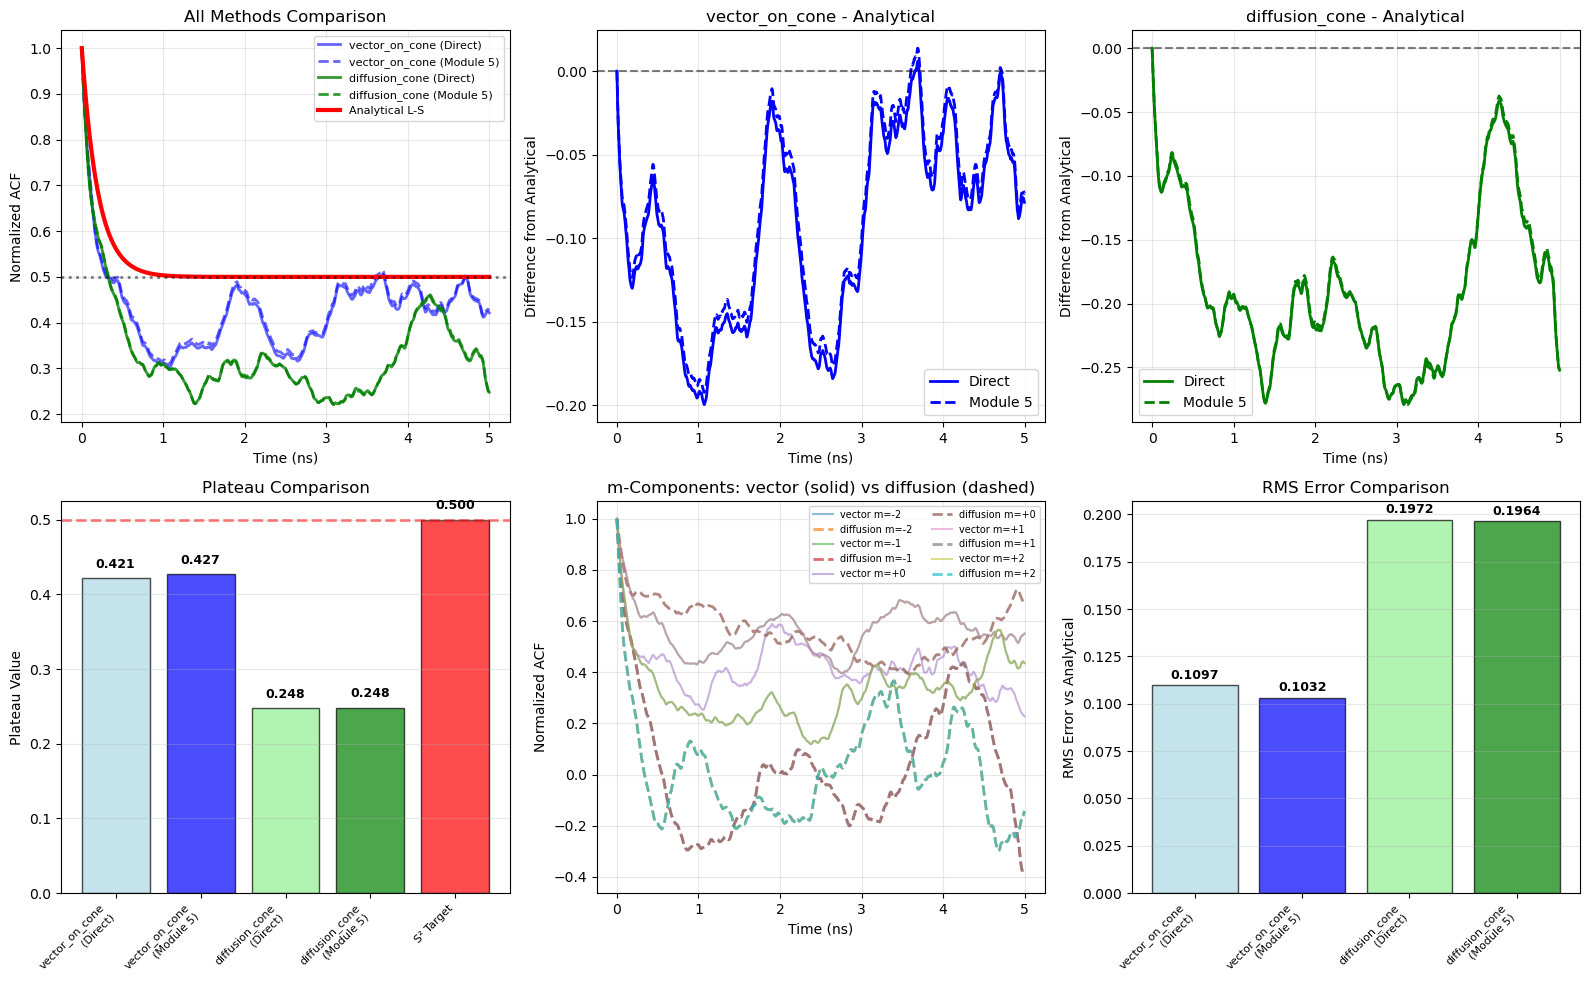


FINAL COMPARISON SUMMARY

vector_on_cone trajectory:
  Direct ensemble avg:   plateau = 0.4215, error = 0.0785, RMS = 0.1097
  Module 5 (Wigner D):   plateau = 0.4266, error = 0.0734, RMS = 0.1032

diffusion_cone trajectory:
  Direct ensemble avg:   plateau = 0.2478, error = 0.2522, RMS = 0.1972
  Module 5 (Wigner D):   plateau = 0.2484, error = 0.2516, RMS = 0.1964

Target S² = 0.5000

BEST METHOD: vector_on_cone (Module 5)
  Plateau error: 0.0734


In [10]:
# Test with diffusion_cone trajectory type (β varies within cone)

print("\n" + "="*70)
print("TEST: diffusion_cone Trajectory Type")
print("="*70)

config_diffusion_cone = NMRConfig(
    trajectory_type='diffusion_cone',  # β varies from 0 to θ_cone
    S2=0.5,
    tau_c=2e-10,
    dt=1e-12,
    num_steps=10000,
    interaction_type='dipolar',
    D_coupling=1.0,
    max_lag=5000,
    lag_step=1,
    verbose=True
)

gen_diffusion_cone = TrajectoryGenerator(config_diffusion_cone)
rotations_diffusion_cone, _ = gen_diffusion_cone.generate()

converter_diffusion_cone = EulerConverter(config_diffusion_cone)
euler_angles_diffusion_cone = converter_diffusion_cone.convert(rotations=rotations_diffusion_cone)

# Calculate Y2m for diffusion_cone
sh_calc_diffusion_cone = SphericalHarmonicsCalculator(config_diffusion_cone, use_sympy=False)
Y2m_diffusion_cone = sh_calc_diffusion_cone.calculate(euler_angles_diffusion_cone)

print(f"\nY2m shape: {Y2m_diffusion_cone.shape}")
print(f"Y2m mean values for each m component:")
for m in range(-2, 3):
    m_idx = m + 2
    print(f"  Y₂^{m:+d}: {np.mean(Y2m_diffusion_cone[:, m_idx]):10.4f}")

# Check beta angle variability
betas = euler_angles_diffusion_cone[:, 1]
print(f"\nBeta angle statistics:")
print(f"  Mean: {np.degrees(np.mean(betas)):.2f}°")
print(f"  Std:  {np.degrees(np.std(betas)):.2f}°")
print(f"  Min:  {np.degrees(np.min(betas)):.2f}°")
print(f"  Max:  {np.degrees(np.max(betas)):.2f}°")

# Calculate autocorrelation
print("\n" + "="*70)
print("Calculating Autocorrelation for diffusion_cone")
print("="*70)

auto_calc_diffusion_cone = AutocorrelationCalculator(config_diffusion_cone)
Co_matrix_diffusion_cone = auto_calc_diffusion_cone.compute_correlation_matrix(Y2m_diffusion_cone)

# Direct ensemble average
acf_diffusion_cone = np.zeros(len(Co_matrix_diffusion_cone[(0,0)]))
for m in range(-2, 3):
    acf_diffusion_cone += Co_matrix_diffusion_cone[(m, m)]
acf_diffusion_cone *= 0.2

acf_diffusion_cone_norm = acf_diffusion_cone / acf_diffusion_cone[0]

print(f"ACF(0) = {acf_diffusion_cone[0]:.4f}")
print(f"ACF(t_max) = {acf_diffusion_cone[-1]:.4f}")
print(f"Normalized plateau = {acf_diffusion_cone_norm[-1]:.4f}")
print(f"Expected S² = {S2:.4f}")
print(f"Plateau vs S² difference = {abs(acf_diffusion_cone_norm[-1] - S2):.4f}")

# Module 5: Wigner D rotation for diffusion_cone
print("\n" + "="*70)
print("Module 5: Wigner D Rotation for diffusion_cone")
print("="*70)

wigner_calc_diffusion_cone = WignerDCalculator(config_diffusion_cone)

acf_diffusion_cone_module5 = np.zeros((n_orientations, len(Co_matrix_diffusion_cone[(0,0)])))

for i, (alpha, beta, gamma) in enumerate(zip(alpha_ensemble, beta_ensemble, gamma_ensemble)):
    if i % 100 == 0:
        print(f"  Processing orientation {i+1}/{n_orientations}...", end='\r')
    
    D_matrix = wigner_calc_diffusion_cone._wigner_d_rank2(alpha, beta, gamma)
    
    for t_idx in range(len(Co_matrix_diffusion_cone[(0,0)])):
        C_rotated = 0.0
        for m1 in range(-2, 3):
            for m2 in range(-2, 3):
                D_0m1_conj = np.conj(D_matrix[m1+2, 0+2])
                D_m20 = D_matrix[m2+2, 0+2]
                C_m1m2 = Co_matrix_diffusion_cone[(m1, m2)][t_idx]
                C_rotated += D_0m1_conj * C_m1m2 * D_m20
        
        acf_diffusion_cone_module5[i, t_idx] = np.real(C_rotated)

print(f"\n  ✓ Calculated rotated ACF for diffusion_cone")

acf_diffusion_cone_module5_mean = np.mean(acf_diffusion_cone_module5, axis=0)
acf_diffusion_cone_module5_norm = acf_diffusion_cone_module5_mean / acf_diffusion_cone_module5_mean[0]

print(f"  Module 5 plateau = {acf_diffusion_cone_module5_norm[-1]:.4f}")
print(f"  Plateau vs S² difference = {abs(acf_diffusion_cone_module5_norm[-1] - S2):.4f}")

# Comprehensive comparison plot
print("\n" + "="*70)
print("Plotting Comprehensive Comparison")
print("="*70)

plt.figure(figsize=(16, 10))

# Plot 1: All methods - vector_on_cone vs diffusion_cone
plt.subplot(2, 3, 1)
plt.plot(time * 1e9, acf_ensemble_avg_norm, 'b-', label='vector_on_cone (Direct)', linewidth=2, alpha=0.6)
plt.plot(time * 1e9, acf_module5_norm, 'b--', label='vector_on_cone (Module 5)', linewidth=2, alpha=0.6)
plt.plot(time * 1e9, acf_diffusion_cone_norm, 'g-', label='diffusion_cone (Direct)', linewidth=2, alpha=0.8)
plt.plot(time * 1e9, acf_diffusion_cone_module5_norm, 'g--', label='diffusion_cone (Module 5)', linewidth=2, alpha=0.8)
plt.plot(time * 1e9, acf_analytical_norm, 'r-', label='Analytical L-S', linewidth=3)
plt.axhline(y=S2, color='k', linestyle=':', alpha=0.5, linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('All Methods Comparison')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Difference from analytical - vector_on_cone
plt.subplot(2, 3, 2)
diff_vector_direct = acf_ensemble_avg_norm - acf_analytical_norm
diff_vector_module5 = acf_module5_norm - acf_analytical_norm
plt.plot(time * 1e9, diff_vector_direct, 'b-', label='Direct', linewidth=2)
plt.plot(time * 1e9, diff_vector_module5, 'b--', label='Module 5', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Difference from Analytical')
plt.title('vector_on_cone - Analytical')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 3: Difference from analytical - diffusion_cone
plt.subplot(2, 3, 3)
diff_diffusion_direct = acf_diffusion_cone_norm - acf_analytical_norm
diff_diffusion_module5 = acf_diffusion_cone_module5_norm - acf_analytical_norm
plt.plot(time * 1e9, diff_diffusion_direct, 'g-', label='Direct', linewidth=2)
plt.plot(time * 1e9, diff_diffusion_module5, 'g--', label='Module 5', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Difference from Analytical')
plt.title('diffusion_cone - Analytical')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 4: Plateau comparison bar chart
plt.subplot(2, 3, 4)
methods = ['vector_on_cone\n(Direct)', 'vector_on_cone\n(Module 5)', 
           'diffusion_cone\n(Direct)', 'diffusion_cone\n(Module 5)', 'S² Target']
plateaus = [acf_ensemble_avg_norm[-1], acf_module5_norm[-1],
            acf_diffusion_cone_norm[-1], acf_diffusion_cone_module5_norm[-1], S2]
colors = ['lightblue', 'blue', 'lightgreen', 'green', 'red']
bars = plt.bar(methods, plateaus, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=S2, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Plateau Value')
plt.title('Plateau Comparison')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, plateaus)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Individual m-component comparison
plt.subplot(2, 3, 5)
for m in range(-2, 3):
    acf_m_vector = Co_matrix[(m, m)] / Co_matrix[(m, m)][0]
    acf_m_diffusion = Co_matrix_diffusion_cone[(m, m)] / Co_matrix_diffusion_cone[(m, m)][0]
    plt.plot(time * 1e9, acf_m_vector, linestyle='-', alpha=0.5, linewidth=1.5, label=f'vector m={m:+d}')
    plt.plot(time * 1e9, acf_m_diffusion, linestyle='--', alpha=0.7, linewidth=2, label=f'diffusion m={m:+d}')
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('m-Components: vector (solid) vs diffusion (dashed)')
plt.legend(fontsize=7, ncol=2)
plt.grid(True, alpha=0.3)

# Plot 6: RMS error summary
plt.subplot(2, 3, 6)
rms_errors = [
    np.sqrt(np.mean(diff_vector_direct**2)),
    np.sqrt(np.mean(diff_vector_module5**2)),
    np.sqrt(np.mean(diff_diffusion_direct**2)),
    np.sqrt(np.mean(diff_diffusion_module5**2))
]
method_labels = ['vector_on_cone\n(Direct)', 'vector_on_cone\n(Module 5)',
                 'diffusion_cone\n(Direct)', 'diffusion_cone\n(Module 5)']
bars = plt.bar(method_labels, rms_errors, color=['lightblue', 'blue', 'lightgreen', 'green'], 
               alpha=0.7, edgecolor='black')
plt.ylabel('RMS Error vs Analytical')
plt.title('RMS Error Comparison')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rms_errors):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Final statistical summary
print("\n" + "="*70)
print("FINAL COMPARISON SUMMARY")
print("="*70)

print(f"\nvector_on_cone trajectory:")
print(f"  Direct ensemble avg:   plateau = {acf_ensemble_avg_norm[-1]:.4f}, error = {abs(acf_ensemble_avg_norm[-1] - S2):.4f}, RMS = {np.sqrt(np.mean(diff_vector_direct**2)):.4f}")
print(f"  Module 5 (Wigner D):   plateau = {acf_module5_norm[-1]:.4f}, error = {abs(acf_module5_norm[-1] - S2):.4f}, RMS = {np.sqrt(np.mean(diff_vector_module5**2)):.4f}")

print(f"\ndiffusion_cone trajectory:")
print(f"  Direct ensemble avg:   plateau = {acf_diffusion_cone_norm[-1]:.4f}, error = {abs(acf_diffusion_cone_norm[-1] - S2):.4f}, RMS = {np.sqrt(np.mean(diff_diffusion_direct**2)):.4f}")
print(f"  Module 5 (Wigner D):   plateau = {acf_diffusion_cone_module5_norm[-1]:.4f}, error = {abs(acf_diffusion_cone_module5_norm[-1] - S2):.4f}, RMS = {np.sqrt(np.mean(diff_diffusion_module5**2)):.4f}")

print(f"\nTarget S² = {S2:.4f}")

# Determine best method
all_errors = [
    ('vector_on_cone (Direct)', abs(acf_ensemble_avg_norm[-1] - S2)),
    ('vector_on_cone (Module 5)', abs(acf_module5_norm[-1] - S2)),
    ('diffusion_cone (Direct)', abs(acf_diffusion_cone_norm[-1] - S2)),
    ('diffusion_cone (Module 5)', abs(acf_diffusion_cone_module5_norm[-1] - S2))
]

best_method = min(all_errors, key=lambda x: x[1])
print(f"\n{'='*70}")
print(f"BEST METHOD: {best_method[0]}")
print(f"  Plateau error: {best_method[1]:.4f}")
print(f"{'='*70}")


## Using Module 5: RotatedCorrelationCalculator

Using the built-in `RotatedCorrelationCalculator` class to properly compute rotated autocorrelation for each m component individually.


MODULE 5: Using RotatedCorrelationCalculator

Generating Wigner D-matrices from random orientations...
  Generated 1000 random orientations

  Computing Wigner D-matrices from Euler angles
    Number of orientations: 1000

MODULE 5: Calculating Wigner-D Rotation Matrices
  Rank: 2 (for NMR interactions)
  Matrix size: 5×5 (m = -2, -1, 0, 1, 2)

  ✓ Calculated 1000 Wigner-D matrices
  ✓ Computed Wigner D-matrices
    Shape: (1000, 5, 5)
  Wigner D-matrix shape: (1000, 5, 5)

Rotating correlation matrix...

MODULE 5: Rotating Correlation Matrices
  Number of orientations: 1000
  Correlation matrix size: 5×5
  Number of lag points: 5000
  Rotating using optimized numba implementation...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  ✓ Rotated correlations computed
    Output shape: (1000, 5, 5, 5000)
  Rotated correlations shape: (1000, 5, 5, 5000)
    (n_orientations=1000, 5x5 matrix, n_lags=5000)

Computing ensemble-averaged correlation matrix...

  Computing ensemble average over 1000 orientations...
  ✓ Ensemble-averaged correlation matrix computed
    Shape: (5, 5, 5000)
  Ensemble-averaged matrix shape: (5, 5, 5000)
    (5x5 matrix, n_lags=5000)

Extracting Individual m-Component ACFs

  m = -2:
    ACF(0) = 0.8519
    ACF(t_max) = 0.3586
    Normalized plateau = 0.4210

  m = -1:
    ACF(0) = 0.8060
    ACF(t_max) = 0.3359
    Normalized plateau = 0.4168

  m = +0:
    ACF(0) = 0.8567
    ACF(t_max) = 0.3695
    Normalized plateau = 0.4313

  m = +1:
    ACF(0) = 0.8060
    ACF(t_max) = 0.3359
    Normalized plateau = 0.4168

  m = +2:
    ACF(0) = 0.8519
    ACF(t_max) = 0.3586
    Normalized plateau = 0.4210

  Total (averaged over all m):
    ACF(0) = 0.8345
    Normalized plateau = 0.4215
    Expected

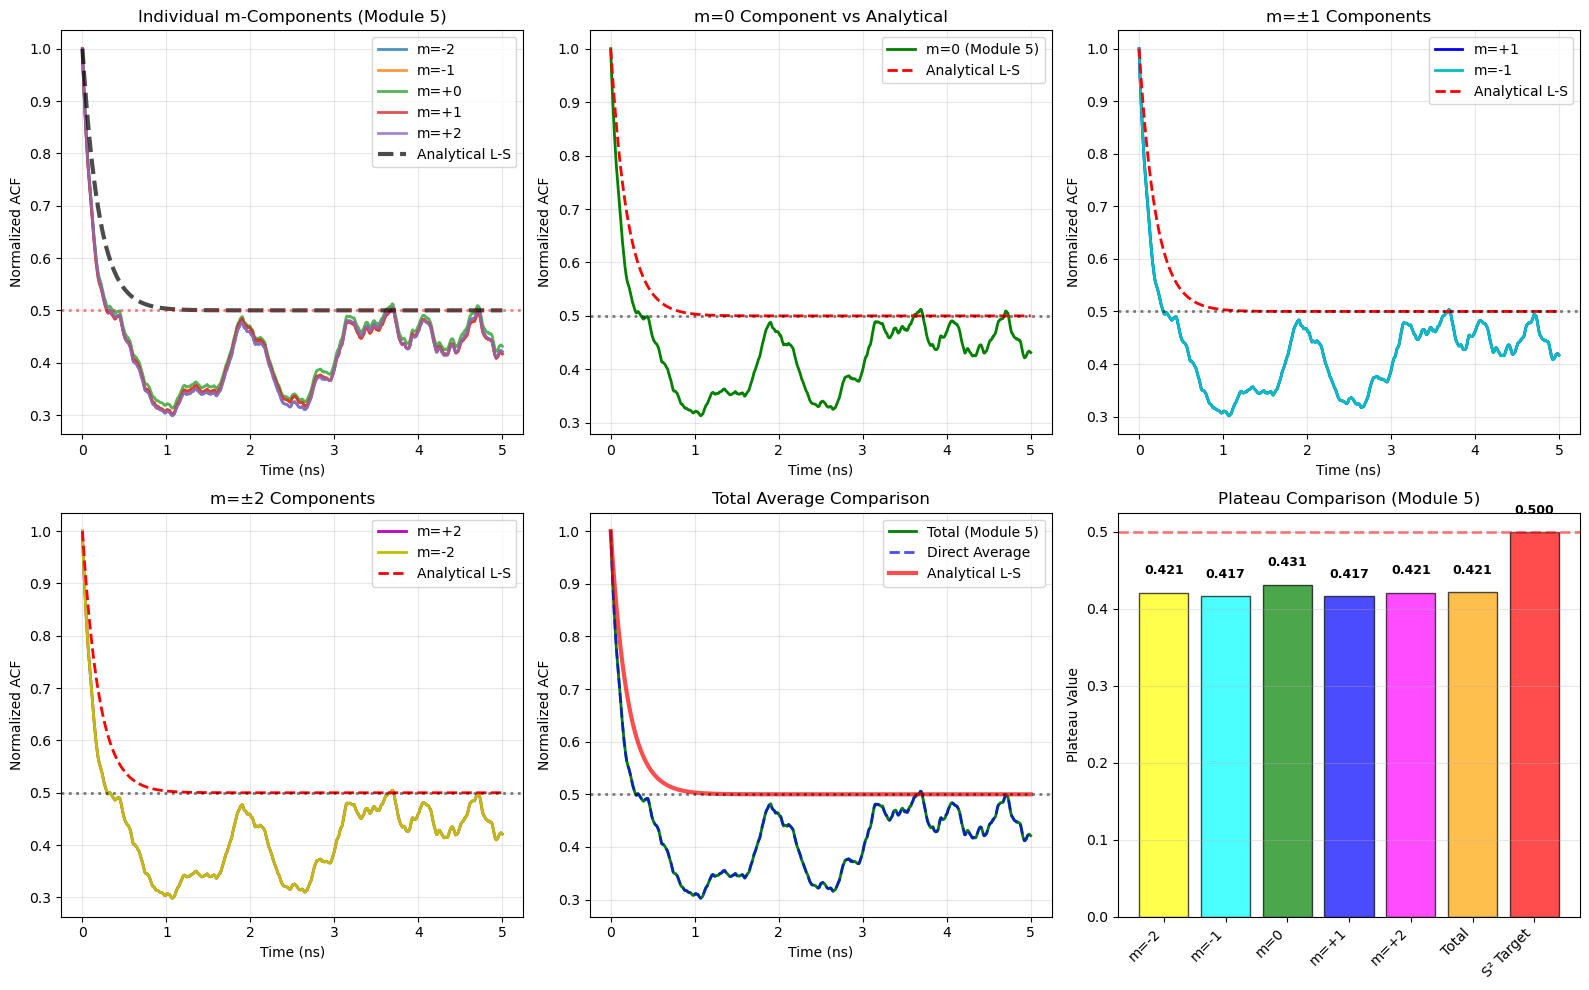


SUMMARY: Module 5 Individual m-Component Analysis

  m = -2:
    Initial value: 0.851926
    Plateau value: 0.420980
    Plateau vs S²: 0.079020

  m = -1:
    Initial value: 0.806017
    Plateau value: 0.416783
    Plateau vs S²: 0.083217

  m = +0:
    Initial value: 0.856684
    Plateau value: 0.431343
    Plateau vs S²: 0.068657

  m = +1:
    Initial value: 0.806017
    Plateau value: 0.416783
    Plateau vs S²: 0.083217

  m = +2:
    Initial value: 0.851926
    Plateau value: 0.420980
    Plateau vs S²: 0.079020

  Total (Σ_m/5):
    Initial value: 0.834514
    Plateau value: 0.421486
    Plateau vs S²: 0.078514

  Target S² = 0.500000


In [11]:
# Use RotatedCorrelationCalculator to compute rotated ACF for each m component

print("\n" + "="*70)
print("MODULE 5: Using RotatedCorrelationCalculator")
print("="*70)

from nmr_calculator.rotated_correlation import RotatedCorrelationCalculator

# Initialize the calculator with vector_on_cone config
rot_corr_calc = RotatedCorrelationCalculator(config_dipolar)

# Generate ensemble of orientations and compute Wigner D-matrices
print("\nGenerating Wigner D-matrices from random orientations...")
n_ensemble = 1000
np.random.seed(42)

# Create ensemble of Euler angles
euler_ensemble = np.column_stack([
    np.random.uniform(0, 2*np.pi, n_ensemble),  # alpha
    np.arccos(np.random.uniform(-1, 1, n_ensemble)),  # beta (uniform on sphere)
    np.random.uniform(0, 2*np.pi, n_ensemble)   # gamma
])

print(f"  Generated {n_ensemble} random orientations")

# Compute Wigner D-matrices from Euler angles
wigner_d_matrices = rot_corr_calc.compute_wigner_d_from_euler(euler_ensemble)
print(f"  Wigner D-matrix shape: {wigner_d_matrices.shape}")

# Rotate the correlation matrix
print("\nRotating correlation matrix...")
rotated_corrs = rot_corr_calc.rotate_correlation_matrix(Co_matrix)

print(f"  Rotated correlations shape: {rotated_corrs.shape}")
print(f"    (n_orientations={rotated_corrs.shape[0]}, 5x5 matrix, n_lags={rotated_corrs.shape[3]})")

# Compute ensemble average
print("\nComputing ensemble-averaged correlation matrix...")
ensemble_avg_matrix = rot_corr_calc.compute_ensemble_average(rotated_corrs)

print(f"  Ensemble-averaged matrix shape: {ensemble_avg_matrix.shape}")
print(f"    (5x5 matrix, n_lags={ensemble_avg_matrix.shape[2]})")

# Extract ACF for each individual m component (diagonal elements)
print("\n" + "="*70)
print("Extracting Individual m-Component ACFs")
print("="*70)

acf_per_m = {}
for i, m in enumerate([-2, -1, 0, 1, 2]):
    # Diagonal element for this m component: C_{m,m}(t)
    acf_per_m[m] = ensemble_avg_matrix[i, i, :].real
    
    # Normalize by initial value
    acf_norm = acf_per_m[m] / acf_per_m[m][0]
    
    print(f"\n  m = {m:+d}:")
    print(f"    ACF(0) = {acf_per_m[m][0]:.4f}")
    print(f"    ACF(t_max) = {acf_per_m[m][-1]:.4f}")
    print(f"    Normalized plateau = {acf_norm[-1]:.4f}")

# Also compute the total ensemble average (sum over all m)
acf_total_module5 = np.zeros(ensemble_avg_matrix.shape[2])
for i in range(5):
    acf_total_module5 += ensemble_avg_matrix[i, i, :].real
acf_total_module5 *= 0.2  # Divide by 5

acf_total_module5_norm = acf_total_module5 / acf_total_module5[0]

print(f"\n  Total (averaged over all m):")
print(f"    ACF(0) = {acf_total_module5[0]:.4f}")
print(f"    Normalized plateau = {acf_total_module5_norm[-1]:.4f}")
print(f"    Expected S² = {S2:.4f}")
print(f"    Difference = {abs(acf_total_module5_norm[-1] - S2):.4f}")

# Plot individual m components
print("\n" + "="*70)
print("Plotting Individual m-Component ACFs (Module 5)")
print("="*70)

plt.figure(figsize=(16, 10))

# Plot 1: All m components - normalized
plt.subplot(2, 3, 1)
for i, m in enumerate([-2, -1, 0, 1, 2]):
    acf_norm = acf_per_m[m] / acf_per_m[m][0]
    plt.plot(time * 1e9, acf_norm, label=f'm={m:+d}', linewidth=2, alpha=0.8)
plt.plot(time * 1e9, acf_analytical_norm, 'k--', label='Analytical L-S', linewidth=3, alpha=0.7)
plt.axhline(y=S2, color='r', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Individual m-Components (Module 5)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: m=0 component comparison
plt.subplot(2, 3, 2)
acf_m0_norm = acf_per_m[0] / acf_per_m[0][0]
plt.plot(time * 1e9, acf_m0_norm, 'g-', label='m=0 (Module 5)', linewidth=2)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical L-S', linewidth=2)
plt.axhline(y=S2, color='k', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('m=0 Component vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: m=±1 components
plt.subplot(2, 3, 3)
acf_m1_pos_norm = acf_per_m[1] / acf_per_m[1][0]
acf_m1_neg_norm = acf_per_m[-1] / acf_per_m[-1][0]
plt.plot(time * 1e9, acf_m1_pos_norm, 'b-', label='m=+1', linewidth=2)
plt.plot(time * 1e9, acf_m1_neg_norm, 'c-', label='m=-1', linewidth=2)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical L-S', linewidth=2)
plt.axhline(y=S2, color='k', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('m=±1 Components')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: m=±2 components
plt.subplot(2, 3, 4)
acf_m2_pos_norm = acf_per_m[2] / acf_per_m[2][0]
acf_m2_neg_norm = acf_per_m[-2] / acf_per_m[-2][0]
plt.plot(time * 1e9, acf_m2_pos_norm, 'm-', label='m=+2', linewidth=2)
plt.plot(time * 1e9, acf_m2_neg_norm, 'y-', label='m=-2', linewidth=2)
plt.plot(time * 1e9, acf_analytical_norm, 'r--', label='Analytical L-S', linewidth=2)
plt.axhline(y=S2, color='k', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('m=±2 Components')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Total average comparison
plt.subplot(2, 3, 5)
plt.plot(time * 1e9, acf_total_module5_norm, 'g-', label='Total (Module 5)', linewidth=2)
plt.plot(time * 1e9, acf_ensemble_avg_norm, 'b--', label='Direct Average', linewidth=2, alpha=0.7)
plt.plot(time * 1e9, acf_analytical_norm, 'r-', label='Analytical L-S', linewidth=3, alpha=0.7)
plt.axhline(y=S2, color='k', linestyle=':', linewidth=2, alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Total Average Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Plateau values for each m
plt.subplot(2, 3, 6)
m_labels = ['m=-2', 'm=-1', 'm=0', 'm=+1', 'm=+2', 'Total', 'S² Target']
plateau_values = []
for m in [-2, -1, 0, 1, 2]:
    acf_norm = acf_per_m[m] / acf_per_m[m][0]
    plateau_values.append(acf_norm[-1])
plateau_values.append(acf_total_module5_norm[-1])
plateau_values.append(S2)

colors = ['yellow', 'cyan', 'green', 'blue', 'magenta', 'orange', 'red']
bars = plt.bar(m_labels, plateau_values, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=S2, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Plateau Value')
plt.title('Plateau Comparison (Module 5)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, plateau_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY: Module 5 Individual m-Component Analysis")
print("="*70)

for m in [-2, -1, 0, 1, 2]:
    acf_norm = acf_per_m[m] / acf_per_m[m][0]
    print(f"\n  m = {m:+d}:")
    print(f"    Initial value: {acf_per_m[m][0]:.6f}")
    print(f"    Plateau value: {acf_norm[-1]:.6f}")
    print(f"    Plateau vs S²: {abs(acf_norm[-1] - S2):.6f}")

print(f"\n  Total (Σ_m/5):")
print(f"    Initial value: {acf_total_module5[0]:.6f}")
print(f"    Plateau value: {acf_total_module5_norm[-1]:.6f}")
print(f"    Plateau vs S²: {abs(acf_total_module5_norm[-1] - S2):.6f}")

print(f"\n  Target S² = {S2:.6f}")
